# Studienarbeit ComputerVision 2
## Differences and Limitations of Unet and SegNet

---

In [1]:
# relevant imports
from torch import nn, optim
from torchsummary import summary
from torchvision.transforms import transforms
from PIL import Image
from ray.train import Checkpoint
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
from typing import List
from matplotlib import pyplot as plt
import pandas as pd
from ray.air import session
from pathlib import Path
from torch.utils.data import random_split
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.functional as F
import torch
import torchmetrics as TM
from monai.networks.nets import UNet
from torch.utils.data import DataLoader
import os


#### Modelarchitecture
![unet_brain_mri.png](https://pytorch.org/assets/images/unet_brain_mri.png)

In [2]:
class UNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(UNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = UNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_2 = UNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_3 = UNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_block_4 = UNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottle_neck_block = UNet._conv_block(256, 512)

        # Decoder Blocks
        self.upconv_block_4 = UNet._upconv_block(512, 256)
        self.decoder_block_4 = UNet._conv_block(512, 256)

        self.upconv_block_3 = UNet._upconv_block(256, 128)
        self.decoder_block_3 = UNet._conv_block(256, 128)

        self.upconv_block_2 = UNet._upconv_block(128, 64)
        self.decoder_block_2 = UNet._conv_block(128, 64)

        self.upconv_block_1 = UNet._upconv_block(64, 32)
        self.decoder_block_1 = UNet._conv_block(64, 32)

        # Output convolution
        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e2 = self.encoder_block_2(self.max_pool_1(e1))
        e3 = self.encoder_block_3(self.max_pool_2(e2))
        e4 = self.encoder_block_4(self.max_pool_3(e3))

        b = self.bottle_neck_block(self.max_pool_4(e4))

        d4 = self.upconv_block_4(b)
        d4 = self.decoder_block_4(torch.cat((d4, e4), dim=1))
        d3 = self.upconv_block_3(d4)
        d3 = self.decoder_block_3(torch.cat((d3, e3), dim=1))
        d2 = self.upconv_block_2(d3)
        d2 = self.decoder_block_2(torch.cat((d2, e2), dim=1))
        d1 = self.upconv_block_1(d2)
        d1 = self.decoder_block_1(torch.cat((d1, e1), dim=1))

        return self.fc(d1)

    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

    @staticmethod
    def _upconv_block(input_size, output_size):
        return nn.ConvTranspose2d(input_size, output_size, kernel_size=2, stride=2)

In [3]:
unet = UNet(3, 1)
unet.cuda()
summary(unet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

---

#### Datapreparation

In [5]:
transform_image = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5]),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda mask: mask - 1),
])

class SynchronizedOxfordIIITPet(OxfordIIITPet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def __getitem__(self, index):
        image, mask = super().__getitem__(index)

        if torch.rand(1) < .5:
            i, j, h, w = transforms.RandomResizedCrop.get_params(image, (.8, 1.0), (3.0 / 4.0, 4.0 / 3.0))
            image, mask = F.resized_crop(image, i, j, h, w, (256, 256)), F.resized_crop(mask, i, j, h, w, (256, 256), Image.NEAREST)
        if torch.rand(1) < .5:
            image, mask = F.hflip(image), F.hflip(mask)
        if torch.rand(1) < .5:
            image, mask = F.vflip(image), F.vflip(mask)

        return image, mask

In [6]:
dataset = SynchronizedOxfordIIITPet(
    root="~/res",
    split="trainval",
    target_types=["segmentation"],
    download=True,
    transform=transform_image,
    target_transform=transform_mask
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = OxfordIIITPet(
    root="~/res",
    split="test",
    target_types=["segmentation"],
    download=True,
    transform=transform_image,
    target_transform=transform_mask
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8595948..1.0].


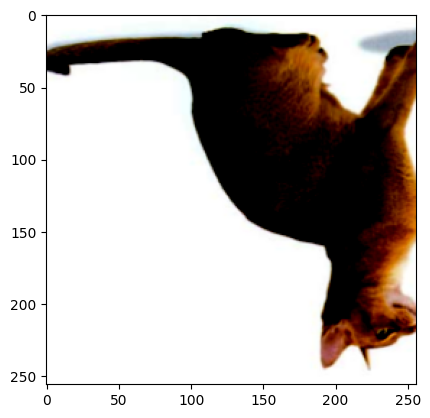

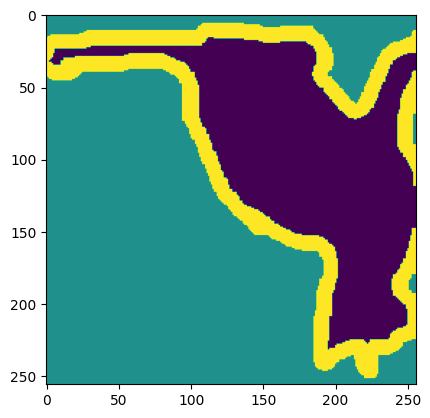

In [8]:
i, m = train_dataset[1]
plt.imshow(i.permute(1,2,0))
plt.show()
plt.imshow(m[0])

In [52]:
dataset.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

---

#### Training

In [10]:
def validation_loop(model: nn.Module, validation_dataloader: DataLoader, loss_fn, device) -> float:
    """
    Validation loop for the CNN
    :param model: neural network
    :param validation_dataloader: dataloader for the validation set
    :param loss_fn: loss function
    :param device: device on which to perform the validation
    :return: validation loss
    """
    running_val_loss: float = 0.
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            inputs, targets = vdata
            inputs, targets = inputs.to(device), targets.squeeze(1).long().to(device)

            vloss = loss_fn(model(inputs), targets)
            running_val_loss += vloss.item()
        running_val_loss /= (i + 1)

    return running_val_loss

In [11]:
def train_loop(model: nn.Module, train_dataloader: DataLoader, loss_fn, optimizer, device) -> float:
    """
    Main minibatch train loop for the CNN
    :param model: neural network
    :param train_dataloader: dataloader for the train set
    :param loss_fn: loss function
    :param optimizer: optimizer
    :param device: device on which to perform the training
    :return: train loss
    """
    running_tr_loss: float = 0.
    for i, data in enumerate(train_dataloader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.squeeze(1).long().to(device)

        yhats = model(inputs)
        optimizer.zero_grad()
        tloss = loss_fn(yhats, targets)

        tloss.backward()
        optimizer.step()

        running_tr_loss += tloss.item()
    running_tr_loss /= (i + 1)

    return running_tr_loss

In [12]:
def train_unet(
        config: dict,
        train_dataset,
        validation_dataset,
        epochs: int,
        apply_scheduler: bool = True,
        return_flag: bool = False) -> dict | None:
    """
    Prepared train loop for ray parameter tuning.
    Training components:
        - model: CNN
        - loss function: CrossEntropyLoss
        - optimizer: Adam
        - scheduler: ExponentialLR (optional)

    :param config: dict of hyperparameters
    :param train_dataset:
    :param validation_dataset:
    :param epochs: number of epochs to train
    :param apply_scheduler: weather scheduler should be used or not
    :param return_flag: weather to return the model and losses or not
    :return: training results
    """

    device: torch.device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
    print(device)
    model: nn.Module = UNet(3, 3).to(device)

    loss_fn = nn.CrossEntropyLoss()

    optim_params: dict = {
        'lr': config["lr"],
    }
    optimizer: optim.Adam = optim.Adam(model.parameters(), **optim_params)

        
    train_dataloader: DataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    validation_dataloader: DataLoader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dataloader), epochs=epochs, pct_start=0.3)

    train_losses: List[float] = []
    val_losses: List[float] = []

    print('Start training...')
    for epoch in tqdm(range(epochs)):
        print('Start: ', epoch)
        model.train()

        # Train loop to iterate over the dataloader batches
        running_tr_loss: float = train_loop(model, train_dataloader, loss_fn, optimizer, device)
        if apply_scheduler:
            scheduler.step()

        # Validation loop
        running_val_loss: float = validation_loop(model, validation_dataloader, loss_fn, device)

        print(epoch, " - ", 'tr_loss:', running_tr_loss, 'val_loss:', running_val_loss)
        train_losses.append(running_tr_loss)
        val_losses.append(running_val_loss)

        # Save a checkpoint from the model
        os.makedirs("res/model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "res/model/checkpoint.pt")
        checkpoint: Checkpoint = Checkpoint.from_directory("res/model")
        session.report({"val_loss": running_val_loss,
                        "train_loss": running_tr_loss}, checkpoint=checkpoint)

    if return_flag:
        return {"train_losses": train_losses,
                "val_losses": val_losses,
                "model": model}

---

#### Training with parameter

In [14]:
config = {'lr': 0.001}

res = train_unet(config, train_dataset, val_dataset, 100, return_flag=True, apply_scheduler=True)

cuda:5
Start training...


  0%|          | 0/100 [00:00<?, ?it/s]

Start:  0
0  -  tr_loss: 0.8441806383754896 val_loss: 1.0446461935838063


/home/jovyan/.local/lib/python3.11/site-packages/ray/train/_internal/session.py:652: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(
  1%|          | 1/100 [00:17<28:11, 17.09s/it]

Start:  1
1  -  tr_loss: 0.6960952346739562 val_loss: 0.7235976755619049


  2%|▏         | 2/100 [00:33<27:30, 16.84s/it]

Start:  2
2  -  tr_loss: 0.6576841136683589 val_loss: 0.6808247019847234


  3%|▎         | 3/100 [00:49<26:42, 16.52s/it]

Start:  3
3  -  tr_loss: 0.6176951696043429 val_loss: 0.6154109140237173


  4%|▍         | 4/100 [01:06<26:21, 16.48s/it]

Start:  4
4  -  tr_loss: 0.6037866512070531 val_loss: 0.6877199361721674


  5%|▌         | 5/100 [01:22<26:04, 16.47s/it]

Start:  5
5  -  tr_loss: 0.5914160997971244 val_loss: 0.5893415162960688


  6%|▌         | 6/100 [01:39<25:52, 16.52s/it]

Start:  6
6  -  tr_loss: 0.5808878774228303 val_loss: 0.574328343073527


  7%|▋         | 7/100 [01:55<25:35, 16.51s/it]

Start:  7
7  -  tr_loss: 0.563363346716632 val_loss: 0.5746681094169617


  8%|▊         | 8/100 [02:12<25:24, 16.57s/it]

Start:  8
8  -  tr_loss: 0.558280973330788 val_loss: 0.5486616392930349


  9%|▉         | 9/100 [02:29<25:17, 16.68s/it]

Start:  9
9  -  tr_loss: 0.5403478404749995 val_loss: 0.5636532952388128


 10%|█         | 10/100 [02:45<24:43, 16.48s/it]

Start:  10
10  -  tr_loss: 0.5138157489507095 val_loss: 0.5024595657984415


 11%|█         | 11/100 [03:01<24:15, 16.35s/it]

Start:  11
11  -  tr_loss: 0.504581146914026 val_loss: 0.5489525745312372


 12%|█▏        | 12/100 [03:17<23:54, 16.30s/it]

Start:  12
12  -  tr_loss: 0.5035998335351115 val_loss: 0.48648853600025177


 13%|█▎        | 13/100 [03:34<23:53, 16.47s/it]

Start:  13
13  -  tr_loss: 0.4895971514608549 val_loss: 0.47190608580907184


 14%|█▍        | 14/100 [03:50<23:18, 16.26s/it]

Start:  14
14  -  tr_loss: 0.46829798234545666 val_loss: 0.4776075482368469


 15%|█▌        | 15/100 [04:06<23:04, 16.29s/it]

Start:  15
15  -  tr_loss: 0.46544547379016876 val_loss: 0.49103734145561856


 16%|█▌        | 16/100 [04:22<22:45, 16.25s/it]

Start:  16
16  -  tr_loss: 0.4585960636968198 val_loss: 0.4709976017475128


 17%|█▋        | 17/100 [04:39<22:29, 16.25s/it]

Start:  17
17  -  tr_loss: 0.4269418917272402 val_loss: 0.41771772255500156


 18%|█▊        | 18/100 [04:55<22:23, 16.38s/it]

Start:  18
18  -  tr_loss: 0.40737324758716253 val_loss: 0.4107912952701251


 19%|█▉        | 19/100 [05:12<22:08, 16.40s/it]

Start:  19
19  -  tr_loss: 0.3954573014508123 val_loss: 0.38755836834510166


 20%|██        | 20/100 [05:28<21:48, 16.36s/it]

Start:  20
20  -  tr_loss: 0.3841873672993287 val_loss: 0.3956934834520022


 21%|██        | 21/100 [05:45<21:37, 16.42s/it]

Start:  21
21  -  tr_loss: 0.38045538573161414 val_loss: 0.37528925637404126


 22%|██▏       | 22/100 [06:01<21:15, 16.35s/it]

Start:  22
22  -  tr_loss: 0.3646423732456954 val_loss: 0.3873092706004779


 23%|██▎       | 23/100 [06:17<20:46, 16.19s/it]

Start:  23
23  -  tr_loss: 0.3741331398487091 val_loss: 0.38873062034447986


 24%|██▍       | 24/100 [06:33<20:43, 16.36s/it]

Start:  24
24  -  tr_loss: 0.36642597486143524 val_loss: 0.3622247849901517


 25%|██▌       | 25/100 [06:50<20:24, 16.32s/it]

Start:  25
25  -  tr_loss: 0.3465492958607881 val_loss: 0.3458929980794589


 26%|██▌       | 26/100 [07:06<20:03, 16.26s/it]

Start:  26
26  -  tr_loss: 0.34174102544784546 val_loss: 0.4025123516718547


 27%|██▋       | 27/100 [07:22<19:54, 16.36s/it]

Start:  27
27  -  tr_loss: 0.34327107408772345 val_loss: 0.3456125532587369


 28%|██▊       | 28/100 [07:38<19:32, 16.29s/it]

Start:  28
28  -  tr_loss: 0.3350651225318079 val_loss: 0.33705034852027893


 29%|██▉       | 29/100 [07:55<19:12, 16.23s/it]

Start:  29
29  -  tr_loss: 0.32369169204131415 val_loss: 0.33557357142368954


 30%|███       | 30/100 [08:11<19:04, 16.35s/it]

Start:  30
30  -  tr_loss: 0.3319009950627451 val_loss: 0.35906488200028736


 31%|███       | 31/100 [08:28<18:57, 16.48s/it]

Start:  31
31  -  tr_loss: 0.33055387502131256 val_loss: 0.33419397721687955


 32%|███▏      | 32/100 [08:47<19:28, 17.18s/it]

Start:  32
32  -  tr_loss: 0.32052174923212634 val_loss: 0.325528251628081


 33%|███▎      | 33/100 [09:03<19:01, 17.04s/it]

Start:  33
33  -  tr_loss: 0.32181958400684857 val_loss: 0.34263598918914795


 34%|███▍      | 34/100 [09:20<18:38, 16.94s/it]

Start:  34
34  -  tr_loss: 0.3160840305297271 val_loss: 0.3386206477880478


 35%|███▌      | 35/100 [09:37<18:10, 16.78s/it]

Start:  35
35  -  tr_loss: 0.31059513014295825 val_loss: 0.316503348449866


 36%|███▌      | 36/100 [09:54<17:56, 16.82s/it]

Start:  36
36  -  tr_loss: 0.3062660052724507 val_loss: 0.31955674787362415


 37%|███▋      | 37/100 [10:11<17:46, 16.93s/it]

Start:  37
37  -  tr_loss: 0.3037011804788009 val_loss: 0.3297690177957217


 38%|███▊      | 38/100 [10:28<17:36, 17.03s/it]

Start:  38
38  -  tr_loss: 0.29980455533317896 val_loss: 0.3130267883340518


 39%|███▉      | 39/100 [10:45<17:16, 16.98s/it]

Start:  39
39  -  tr_loss: 0.2985091922075852 val_loss: 0.32552623997131985


 40%|████      | 40/100 [11:02<16:54, 16.91s/it]

Start:  40
40  -  tr_loss: 0.29546983540058136 val_loss: 0.3307886893550555


 41%|████      | 41/100 [11:18<16:34, 16.85s/it]

Start:  41
41  -  tr_loss: 0.2973363104721774 val_loss: 0.30313990265130997


 42%|████▏     | 42/100 [11:34<16:05, 16.64s/it]

Start:  42
42  -  tr_loss: 0.2858542751358903 val_loss: 0.3083699072400729


 43%|████▎     | 43/100 [11:51<15:42, 16.54s/it]

Start:  43
43  -  tr_loss: 0.28976844996213913 val_loss: 0.341571606695652


 44%|████▍     | 44/100 [12:08<15:33, 16.67s/it]

Start:  44
44  -  tr_loss: 0.28798237928877707 val_loss: 0.31376367807388306


 45%|████▌     | 45/100 [12:24<15:13, 16.61s/it]

Start:  45
45  -  tr_loss: 0.28780413969703345 val_loss: 0.2965987945596377


 46%|████▌     | 46/100 [12:41<14:58, 16.64s/it]

Start:  46
46  -  tr_loss: 0.27470347447239835 val_loss: 0.29540104418992996


 47%|████▋     | 47/100 [12:57<14:38, 16.57s/it]

Start:  47
47  -  tr_loss: 0.2730302211383115 val_loss: 0.29676703612009686


 48%|████▊     | 48/100 [13:14<14:20, 16.55s/it]

Start:  48
48  -  tr_loss: 0.2661237904559011 val_loss: 0.2865915236373742


 49%|████▉     | 49/100 [13:30<14:04, 16.56s/it]

Start:  49
49  -  tr_loss: 0.26570819804201956 val_loss: 0.29417992879947025


 50%|█████     | 50/100 [13:47<13:48, 16.57s/it]

Start:  50
50  -  tr_loss: 0.2652169336443362 val_loss: 0.3011465643843015


 51%|█████     | 51/100 [14:04<13:37, 16.68s/it]

Start:  51
51  -  tr_loss: 0.2603185740501984 val_loss: 0.29403967907031375


 52%|█████▏    | 52/100 [14:21<13:19, 16.65s/it]

Start:  52
52  -  tr_loss: 0.2564990102596905 val_loss: 0.2966843644777934


 53%|█████▎    | 53/100 [14:37<13:03, 16.66s/it]

Start:  53
53  -  tr_loss: 0.25386457048032596 val_loss: 0.28651004781325656


 54%|█████▍    | 54/100 [14:54<12:42, 16.57s/it]

Start:  54
54  -  tr_loss: 0.2591356878047404 val_loss: 0.3090412380794684


 55%|█████▌    | 55/100 [15:10<12:22, 16.49s/it]

Start:  55
55  -  tr_loss: 0.2527123349516288 val_loss: 0.27999626100063324


 56%|█████▌    | 56/100 [15:27<12:10, 16.61s/it]

Start:  56
56  -  tr_loss: 0.2512587389868239 val_loss: 0.3194446886579196


 57%|█████▋    | 57/100 [15:44<11:56, 16.66s/it]

Start:  57
57  -  tr_loss: 0.2485527230993561 val_loss: 0.2880653217434883


 58%|█████▊    | 58/100 [16:00<11:43, 16.75s/it]

Start:  58
58  -  tr_loss: 0.24218365614828857 val_loss: 0.2934937812387943


 59%|█████▉    | 59/100 [16:17<11:27, 16.76s/it]

Start:  59
59  -  tr_loss: 0.2471699312977169 val_loss: 0.3062177648146947


 60%|██████    | 60/100 [16:33<11:01, 16.54s/it]

Start:  60
60  -  tr_loss: 0.24244973581770193 val_loss: 0.29257379844784737


 61%|██████    | 61/100 [16:51<10:53, 16.75s/it]

Start:  61
61  -  tr_loss: 0.23650700339804526 val_loss: 0.2904694117605686


 62%|██████▏   | 62/100 [17:07<10:38, 16.81s/it]

Start:  62
62  -  tr_loss: 0.23889020441666894 val_loss: 0.28246982395648956


 63%|██████▎   | 63/100 [17:24<10:15, 16.63s/it]

Start:  63
63  -  tr_loss: 0.23380650288384894 val_loss: 0.29375432183345157


 64%|██████▍   | 64/100 [17:40<09:55, 16.54s/it]

Start:  64
64  -  tr_loss: 0.23234081721824149 val_loss: 0.2770738589266936


 65%|██████▌   | 65/100 [17:56<09:38, 16.52s/it]

Start:  65
65  -  tr_loss: 0.23252966902826144 val_loss: 0.2992084709306558


 66%|██████▌   | 66/100 [18:13<09:21, 16.50s/it]

Start:  66
66  -  tr_loss: 0.23021202145711236 val_loss: 0.3210299387574196


 67%|██████▋   | 67/100 [18:30<09:05, 16.53s/it]

Start:  67
67  -  tr_loss: 0.22630870374648468 val_loss: 0.27188679079214734


 68%|██████▊   | 68/100 [18:46<08:49, 16.56s/it]

Start:  68
68  -  tr_loss: 0.2264946501540101 val_loss: 0.28724049404263496


 69%|██████▉   | 69/100 [19:02<08:30, 16.48s/it]

Start:  69
69  -  tr_loss: 0.22138626419979593 val_loss: 0.2809105229874452


 70%|███████   | 70/100 [19:19<08:13, 16.44s/it]

Start:  70
70  -  tr_loss: 0.2217813908405926 val_loss: 0.2664707563817501


 71%|███████   | 71/100 [19:35<07:53, 16.31s/it]

Start:  71
71  -  tr_loss: 0.21729978919029236 val_loss: 0.28321833287676174


 72%|███████▏  | 72/100 [19:52<07:40, 16.45s/it]

Start:  72
72  -  tr_loss: 0.2149530198910962 val_loss: 0.28428365911046666


 73%|███████▎  | 73/100 [20:08<07:25, 16.50s/it]

Start:  73
73  -  tr_loss: 0.2167913087684175 val_loss: 0.2759857699275017


 74%|███████▍  | 74/100 [20:25<07:10, 16.55s/it]

Start:  74
74  -  tr_loss: 0.20928459808878278 val_loss: 0.2746834419667721


 75%|███████▌  | 75/100 [20:41<06:52, 16.50s/it]

Start:  75
75  -  tr_loss: 0.2066895187548969 val_loss: 0.2744450395305951


 76%|███████▌  | 76/100 [20:58<06:37, 16.55s/it]

Start:  76
76  -  tr_loss: 0.206831819013409 val_loss: 0.28338845695058507


 77%|███████▋  | 77/100 [21:15<06:23, 16.67s/it]

Start:  77
77  -  tr_loss: 0.20719842645137207 val_loss: 0.281678032130003


 78%|███████▊  | 78/100 [21:32<06:06, 16.67s/it]

Start:  78
78  -  tr_loss: 0.20859016834393793 val_loss: 0.26825269187490147


 79%|███████▉  | 79/100 [21:48<05:50, 16.71s/it]

Start:  79
79  -  tr_loss: 0.2005837886877682 val_loss: 0.277109923462073


 80%|████████  | 80/100 [22:05<05:31, 16.56s/it]

Start:  80
80  -  tr_loss: 0.20030723771323328 val_loss: 0.3012225975592931


 81%|████████  | 81/100 [22:21<05:15, 16.58s/it]

Start:  81
81  -  tr_loss: 0.2045970322645229 val_loss: 0.2993002024789651


 82%|████████▏ | 82/100 [22:37<04:55, 16.42s/it]

Start:  82
82  -  tr_loss: 0.19220791465562323 val_loss: 0.2903055474162102


 83%|████████▎ | 83/100 [22:54<04:39, 16.47s/it]

Start:  83
83  -  tr_loss: 0.19222899655932965 val_loss: 0.2844737283885479


 84%|████████▍ | 84/100 [23:11<04:28, 16.79s/it]

Start:  84
84  -  tr_loss: 0.19982153274442838 val_loss: 0.28399290641148883


 85%|████████▌ | 85/100 [23:29<04:14, 16.94s/it]

Start:  85
85  -  tr_loss: 0.19285016021002893 val_loss: 0.2799961653848489


 86%|████████▌ | 86/100 [23:45<03:54, 16.78s/it]

Start:  86
86  -  tr_loss: 0.19423402910647186 val_loss: 0.3068309351801872


 87%|████████▋ | 87/100 [24:02<03:37, 16.76s/it]

Start:  87
87  -  tr_loss: 0.18975259622801904 val_loss: 0.27657900253931683


 88%|████████▊ | 88/100 [24:19<03:21, 16.78s/it]

Start:  88
88  -  tr_loss: 0.1874505877494812 val_loss: 0.27545153597990674


 89%|████████▉ | 89/100 [24:35<03:04, 16.75s/it]

Start:  89
89  -  tr_loss: 0.18537068852911825 val_loss: 0.28181928644577664


 90%|█████████ | 90/100 [24:52<02:48, 16.80s/it]

Start:  90
90  -  tr_loss: 0.1801942411972129 val_loss: 0.27947262053688365


 91%|█████████ | 91/100 [25:09<02:30, 16.72s/it]

Start:  91
91  -  tr_loss: 0.1798067261343417 val_loss: 0.27858089034756023


 92%|█████████▏| 92/100 [25:26<02:14, 16.76s/it]

Start:  92
92  -  tr_loss: 0.1787394421256107 val_loss: 0.2779516602555911


 93%|█████████▎| 93/100 [25:43<01:57, 16.80s/it]

Start:  93
93  -  tr_loss: 0.18197256132312442 val_loss: 0.2890217912693818


 94%|█████████▍| 94/100 [25:59<01:40, 16.75s/it]

Start:  94
94  -  tr_loss: 0.1805202776323194 val_loss: 0.2793464461962382


 95%|█████████▌| 95/100 [26:16<01:24, 16.89s/it]

Start:  95
95  -  tr_loss: 0.17849408802778824 val_loss: 0.27423616250356037


 96%|█████████▌| 96/100 [26:33<01:06, 16.73s/it]

Start:  96
96  -  tr_loss: 0.18199096976414972 val_loss: 0.2862689917286237


 97%|█████████▋| 97/100 [26:49<00:49, 16.63s/it]

Start:  97
97  -  tr_loss: 0.1767853777045789 val_loss: 0.27503835906585056


 98%|█████████▊| 98/100 [27:06<00:33, 16.69s/it]

Start:  98
98  -  tr_loss: 0.17406071268993875 val_loss: 0.2770899000267188


 99%|█████████▉| 99/100 [27:23<00:16, 16.73s/it]

Start:  99
99  -  tr_loss: 0.17169411091700845 val_loss: 0.287008136510849


100%|██████████| 100/100 [27:41<00:00, 16.61s/it]


In [15]:
val_losses = res['val_losses']
tr_losses = res['train_losses']
model = res['model']

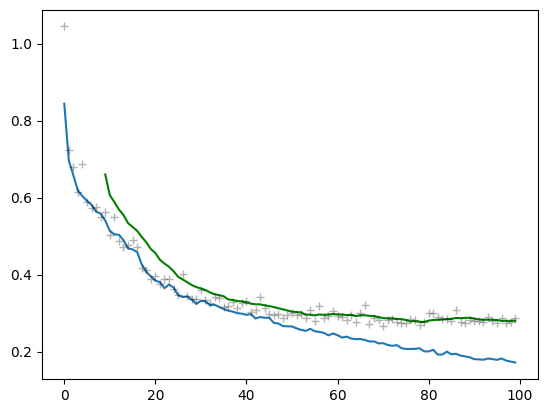

In [16]:
plt.plot(tr_losses)
plt.plot(pd.Series(val_losses).rolling(10).mean(), color='g')
plt.plot(val_losses, 'k+', alpha=0.3)
plt.show()

---

#### Evaluation

In [18]:
torch.save(model, '../../res/checkpoints/unet_pets_full.pt')
torch.save(model.state_dict(), '../../res/checkpoints/unet_pets.pt')

In [7]:
def load_checkpoint(path: Path, model: torch.nn.Module) -> torch.nn.Module:
    """
    Helper method to load a model from a checkpoint
    :param path: path to checkpoint
    :param model: model which should use the checkpoint
    :return: loaded model
    """
    device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

In [8]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = UNet(3, 3).to(device)

net = load_checkpoint(Path('../../res/checkpoints/unet_pets.pt'), net)

In [9]:
def evaluate_model(model: torch.nn.Module, data_loader: DataLoader, device) -> None:
    """
    Evaluate the pixel accuracy and the Intersection over Union (IoU) for the model
    :param model: neural network
    :param data_loader: torch DataLoader
    :param device: device on which to perform the evaluation
    :return: None
    """
    model.eval()

    iou_scores = []
    pixel_acc_scores = []
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            pred = nn.Softmax(dim=1)(outputs)
            pred = pred.argmax(dim=1)
            pred = pred.unsqueeze(1).long().to(device)

            iou = TM.classification.MulticlassJaccardIndex(35, average='macro').to(device)
            iou_score = iou(pred, targets)
            iou_scores.append(iou_score.item())

            pixel_metric = TM.classification.MulticlassAccuracy(35, average='macro').to(device)
            pixel_acc_score = pixel_metric(pred, targets)
            pixel_acc_scores.append(pixel_acc_score.item())

        iou_tensor = torch.FloatTensor(iou_scores)
        pixel_tensor = torch.FloatTensor(pixel_acc_scores)
        print(f"Iou: {iou_tensor.mean()}")
        print(f'Pixel Accuracy: {pixel_tensor.mean()}')


In [10]:
evaluate_model(net, test_dataloader, device)

100%|██████████| 58/58 [16:37<00:00, 17.20s/it]

Iou: 0.7058774828910828
Pixel Accuracy: 0.8299434185028076
